<a href="https://colab.research.google.com/github/Niharikaaa5/Parkinsons_Disease-Detection/blob/main/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LOADING AND EXPLORING DATASET
Dataset loaded successfully! Shape: (195, 24)

First 5 rows:
              name  MDVP:Fo(Hz)  MDVP:Fhi(Hz)  MDVP:Flo(Hz)  MDVP:Jitter(%)  \
0  phon_R01_S01_1      119.992       157.302        74.997         0.00784   
1  phon_R01_S01_2      122.400       148.650       113.819         0.00968   
2  phon_R01_S01_3      116.682       131.111       111.555         0.01050   
3  phon_R01_S01_4      116.676       137.871       111.366         0.00997   
4  phon_R01_S01_5      116.014       141.781       110.655         0.01284   

   MDVP:Jitter(Abs)  MDVP:RAP  MDVP:PPQ  Jitter:DDP  MDVP:Shimmer  ...  \
0           0.00007   0.00370   0.00554     0.01109       0.04374  ...   
1           0.00008   0.00465   0.00696     0.01394       0.06134  ...   
2           0.00009   0.00544   0.00781     0.01633       0.05233  ...   
3           0.00009   0.00502   0.00698     0.01505       0.05492  ...   
4           0.00011   0.00655   0.00908     0.01966       0.06425  ..

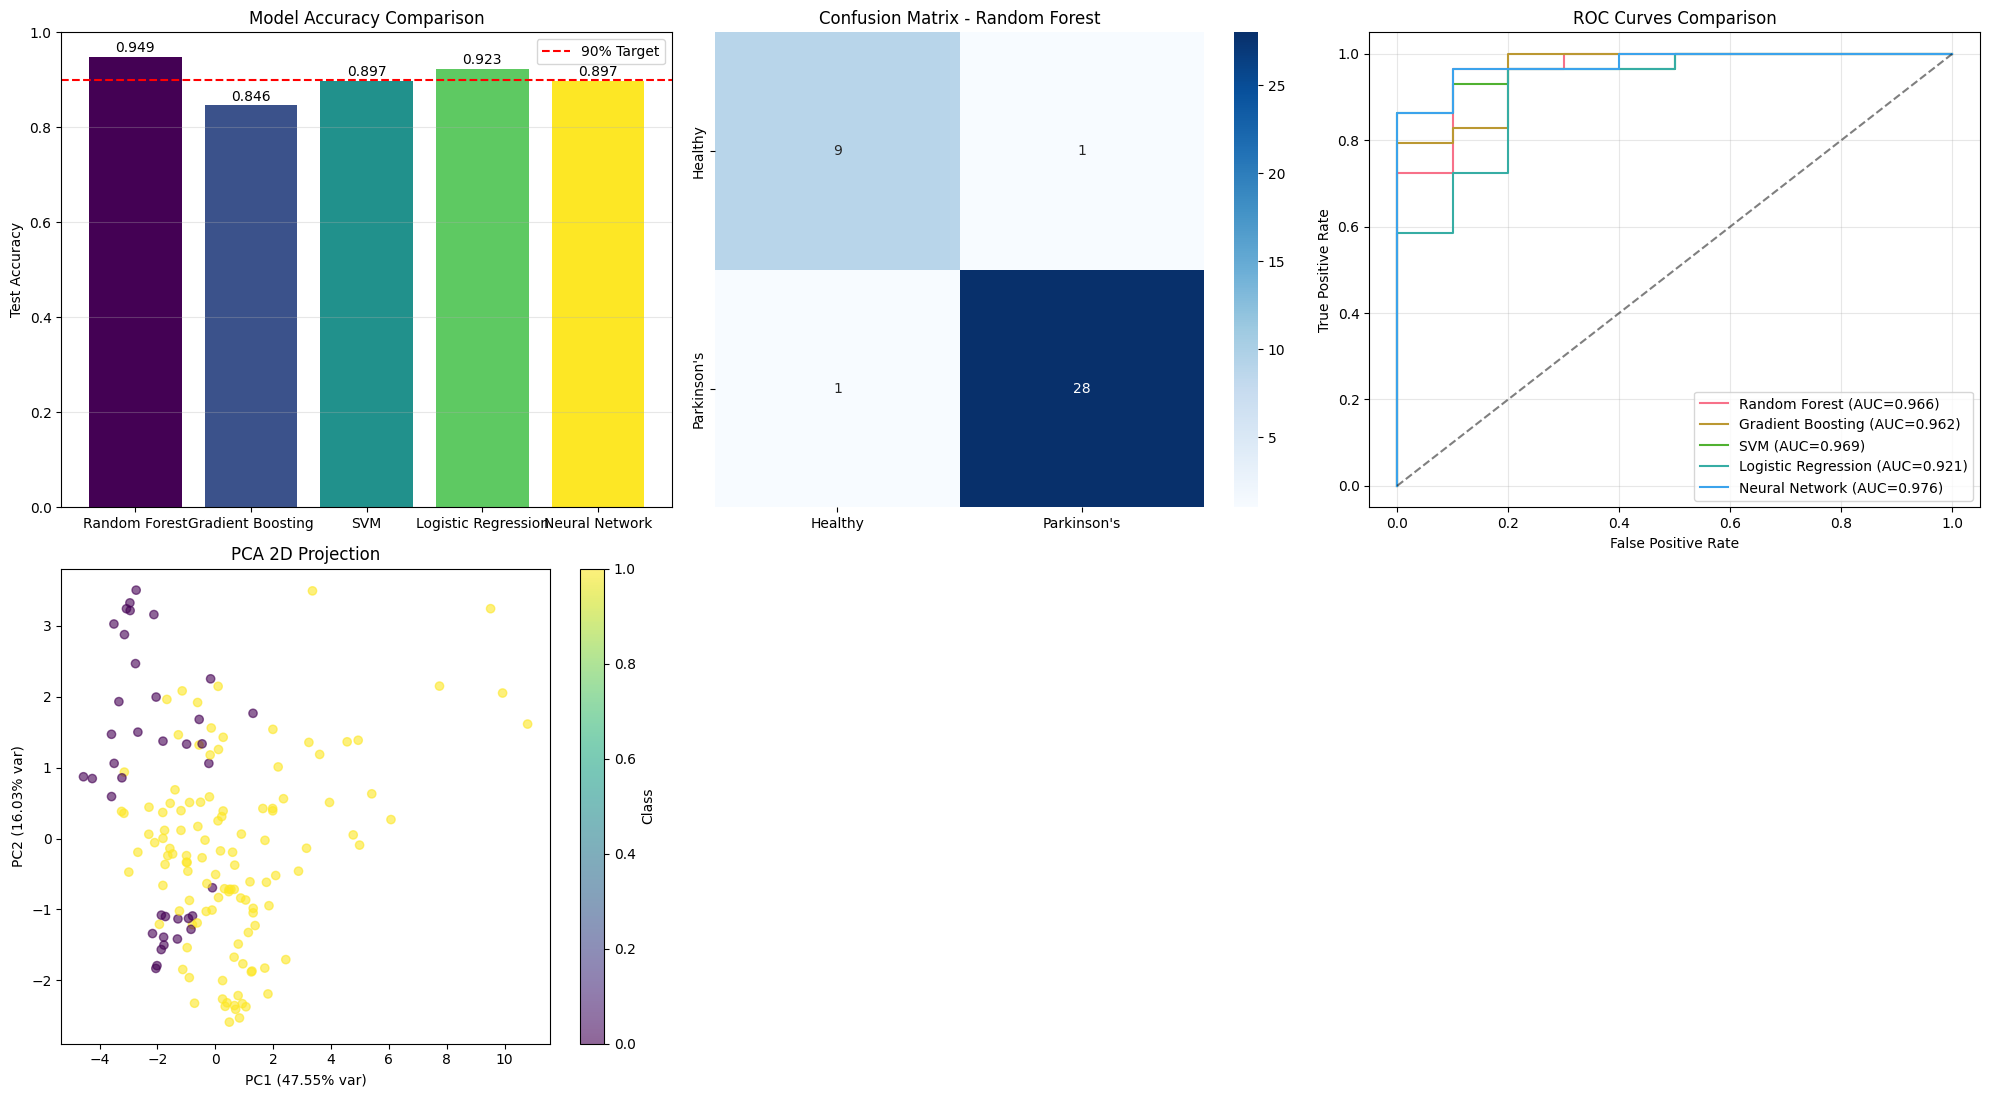


Creating SHAP Analysis...


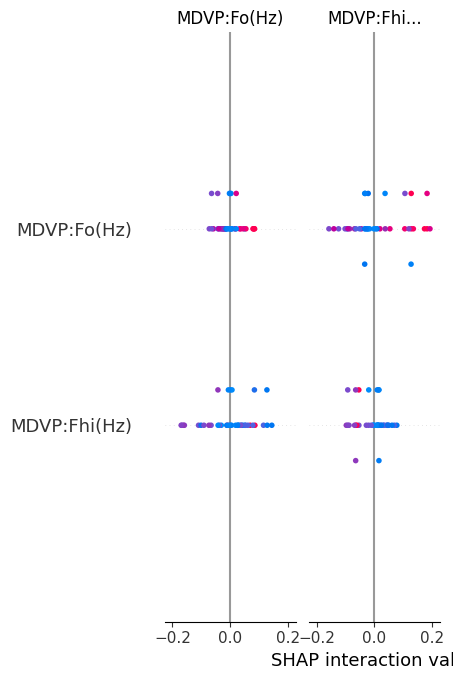

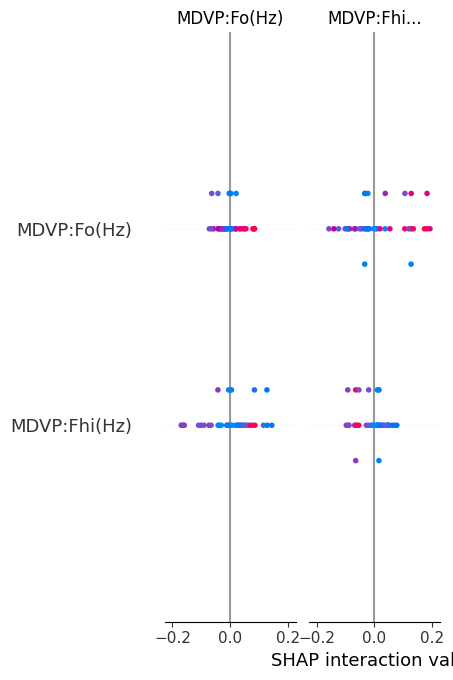

SHAP analysis failed: Data must be 1-dimensional, got ndarray of shape (13, 2) instead
FINAL REPORT
Best Model: Random Forest
Test Accuracy: 0.9487
Precision: 0.9655
Recall: 0.9655
F1-Score: 0.9655
ROC-AUC: 0.9655
Cross-Validation: 0.9167 ± 0.0327
UNSUPERVISED CLUSTERING ANALYSIS


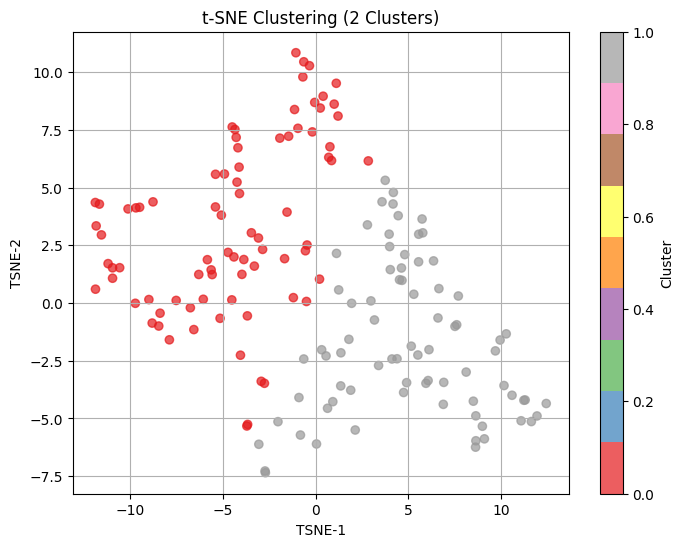

Cluster counts: [80 76]

 PROJECT COMPLETED! Best Model: Random Forest


In [8]:
# Parkinson's Disease Voice-Based Detection - Complete ML Pipeline
# Dataset: Parkinson's Speech Dataset from UCI ML Repository

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
from sklearn.decomposition import PCA
import shap
import warnings
warnings.filterwarnings('ignore')
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

plt.style.use('default')
sns.set_palette("husl")

class ParkinsonsPrediction:
    def __init__(self):
        self.scaler = StandardScaler()
        self.models = {}
        self.best_model = None
        self.best_model_name = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None

    def load_and_explore_data(self, url):

        print("LOADING AND EXPLORING DATASET")

        try:
            self.data = pd.read_csv(url)
            print(f"Dataset loaded successfully! Shape: {self.data.shape}")
            print("\nFirst 5 rows:\n", self.data.head())
            print("\nMissing values:\n", self.data.isnull().sum().sum())
            target_col = 'status' if 'status' in self.data.columns else 'class' if 'class' in self.data.columns else self.data.columns[-1]
            print(f"\nTarget variable distribution ({target_col}):")
            print(self.data[target_col].value_counts())
            return True
        except Exception as e:
            print(f"Error loading dataset: {e}")
            return False

    def preprocess_data(self):
        print("DATA PREPROCESSING AND CLEANING")

        target_col = 'status' if 'status' in self.data.columns else 'class' if 'class' in self.data.columns else self.data.columns[-1]

        if 'name' in self.data.columns:
            self.data = self.data.drop('name', axis=1)
            print("Removed 'name' column")

        X = self.data.drop(target_col, axis=1)
        y = self.data[target_col]

        if y.dtype == 'object' or len(y.unique()) > 2:
            le = LabelEncoder()
            y = le.fit_transform(y)
            print(f"Target encoded: {le.classes_}")

        if X.isnull().sum().sum() > 0:
            X = X.fillna(X.median())
            print("Missing values filled with median")


        corr_matrix = X.corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)]
        if to_drop:
            X = X.drop(to_drop, axis=1)
            print(f"Removed {len(to_drop)} highly correlated features")

        X_scaled = self.scaler.fit_transform(X)
        X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        print(f"Final dataset shape: {X_scaled.shape}")
        print(f"Target distribution: {np.bincount(y)}")
        return X_scaled, y

    def split_data(self, X, y):

        print("DATA SPLITTING")

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        print(f"Training set shape: {self.X_train.shape}, Test set shape: {self.X_test.shape}")
        print(f"Training target distribution: {np.bincount(self.y_train)}, Test target distribution: {np.bincount(self.y_test)}")

    def train_models(self):
        print("MODEL TRAINING AND EVALUATION")

        models = {
            'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42),
            'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, random_state=42),
            'SVM': SVC(kernel='rbf', C=10, gamma='scale', probability=True, random_state=42),
            'Logistic Regression': LogisticRegression(C=1.0, max_iter=1000, random_state=42),
            'Neural Network': MLPClassifier(hidden_layer_sizes=(30,15), max_iter=200, alpha=0.5, random_state=42)


        }

        results = {}
        best_score = 0

        for name, model in models.items():
            print(f"\nTraining {name}...")
            model.fit(self.X_train, self.y_train)
            y_pred_test = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:,1] if hasattr(model, 'predict_proba') else None


            test_acc = accuracy_score(self.y_test, y_pred_test)
            precision = precision_score(self.y_test, y_pred_test)
            recall = recall_score(self.y_test, y_pred_test)
            f1 = f1_score(self.y_test, y_pred_test)
            roc_auc = roc_auc_score(self.y_test, y_pred_proba) if y_pred_proba is not None else 0
            cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5, scoring='accuracy')

            results[name] = {
                'model': model,
                'test_accuracy': test_acc,
                'precision': precision,
                'recall': recall,
                'f1_score': f1,
                'roc_auc': roc_auc,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'y_pred': y_pred_test,
                'y_pred_proba': y_pred_proba
            }

            print(f"Test Accuracy: {test_acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}, ROC-AUC: {roc_auc:.4f}, CV: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

            if test_acc > best_score:
                best_score = test_acc
                self.best_model_name = name
                self.best_model = model

        self.models = results
        print(f"\n BEST MODEL: {self.best_model_name} with accuracy: {best_score:.4f}")
        return results

    def create_visualizations(self):

        print("CREATING VISUALIZATIONS")


        fig = plt.figure(figsize=(20,16))

        plt.subplot(3,3,1)
        model_names = list(self.models.keys())
        accuracies = [self.models[name]['test_accuracy'] for name in model_names]
        bars = plt.bar(model_names, accuracies, color=plt.cm.viridis(np.linspace(0,1,len(model_names))))
        plt.title("Model Accuracy Comparison")
        plt.ylabel("Test Accuracy")
        plt.ylim(0,1)
        for bar, acc in zip(bars, accuracies):
            plt.text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.01, f"{acc:.3f}", ha='center')
        plt.axhline(0.9, color='red', linestyle='--', label='90% Target')
        plt.legend()
        plt.grid(axis='y', alpha=0.3)


        plt.subplot(3,3,2)
        best_predictions = self.models[self.best_model_name]['y_pred']
        cm = confusion_matrix(self.y_test, best_predictions)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy','Parkinson\'s'],
                    yticklabels=['Healthy','Parkinson\'s'])
        plt.title(f"Confusion Matrix - {self.best_model_name}")


        plt.subplot(3,3,3)
        for name, result in self.models.items():
            if result['y_pred_proba'] is not None:
                fpr, tpr, _ = roc_curve(self.y_test, result['y_pred_proba'])
                plt.plot(fpr, tpr, label=f"{name} (AUC={result['roc_auc']:.3f})")
        plt.plot([0,1],[0,1],'k--',alpha=0.5)
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curves Comparison")
        plt.legend()
        plt.grid(alpha=0.3)


        plt.subplot(3,3,4)
        pca_2d = PCA(n_components=2)
        X_pca_2d = pca_2d.fit_transform(self.X_train)
        plt.scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=self.y_train, cmap='viridis', alpha=0.6)
        plt.xlabel(f"PC1 ({pca_2d.explained_variance_ratio_[0]:.2%} var)")
        plt.ylabel(f"PC2 ({pca_2d.explained_variance_ratio_[1]:.2%} var)")
        plt.title("PCA 2D Projection")
        plt.colorbar(label='Class')

        plt.tight_layout()
        plt.show()

    def create_shap_analysis(self):
        print("\nCreating SHAP Analysis...")

        try:
            if self.best_model_name in ['Random Forest', 'Gradient Boosting']:
                explainer = shap.TreeExplainer(self.best_model)

                shap_values = explainer(self.X_test.values)


                shap.summary_plot(shap_values.values, self.X_test, plot_type="bar", show=True)
                shap.summary_plot(shap_values.values, self.X_test, show=True)


                importances = np.abs(shap_values.values).mean(0)
                top_features = pd.Series(importances, index=self.X_test.columns).sort_values(ascending=False).head(5)
                print("\nTop 5 most important features:")
                print(top_features)

                df_shap = pd.DataFrame(shap_values.values, columns=self.X_test.columns)
                df_shap['target'] = self.y_test.reset_index(drop=True)
                print("\nAverage SHAP values by class:")
                print(df_shap.groupby('target').mean().T.sort_values(by=0, ascending=False).head(5))

            else:
                print(f"SHAP not supported for {self.best_model_name}, skipping detailed SHAP plots.")

        except Exception as e:
            print(f"SHAP analysis failed: {e}")



    def generate_final_report(self):

        print("FINAL REPORT")

        print(f"Best Model: {self.best_model_name}")
        best_result = self.models[self.best_model_name]
        print(f"Test Accuracy: {best_result['test_accuracy']:.4f}")
        print(f"Precision: {best_result['precision']:.4f}")
        print(f"Recall: {best_result['recall']:.4f}")
        print(f"F1-Score: {best_result['f1_score']:.4f}")
        print(f"ROC-AUC: {best_result['roc_auc']:.4f}")
        print(f"Cross-Validation: {best_result['cv_mean']:.4f} ± {best_result['cv_std']:.4f}")

    def visualize_clustering(self):

        print("UNSUPERVISED CLUSTERING ANALYSIS")


        tsne = TSNE(n_components=2, random_state=42, perplexity=30)
        X_tsne = tsne.fit_transform(self.X_train)

        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(X_tsne)

        plt.figure(figsize=(8,6))
        plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters, cmap='Set1', alpha=0.7)
        plt.title("t-SNE Clustering (2 Clusters)")
        plt.xlabel("TSNE-1")
        plt.ylabel("TSNE-2")
        plt.grid(True)
        plt.colorbar(label='Cluster')
        plt.show()

        print(f"Cluster counts: {np.bincount(clusters)}")


def main():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
    predictor = ParkinsonsPrediction()
    if predictor.load_and_explore_data(url):
        X, y = predictor.preprocess_data()
        predictor.split_data(X, y)
        predictor.train_models()
        predictor.create_visualizations()
        predictor.create_shap_analysis()
        predictor.generate_final_report()
        predictor.visualize_clustering()


        print(f"\n PROJECT COMPLETED! Best Model: {predictor.best_model_name}")
    else:
        print(" Failed to load dataset.")

if __name__ == "__main__":
    main()

In [9]:
def main():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/parkinsons.data"
    predictor = ParkinsonsPrediction()
    if predictor.load_and_explore_data(url):
        X, y = predictor.preprocess_data()
        predictor.split_data(X, y)
        predictor.train_models()
        predictor.create_visualizations()
        predictor.generate_final_report()
        print(f"\n PROJECT COMPLETED! Best Model: {predictor.best_model_name}")
    else:
        print(" Failed to load dataset.")